In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv


In [2]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizerFast, BertModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

2025-06-01 08:31:10.458921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748766670.717591      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748766670.788561      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load data
df = pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv")
df = df[['Review Text', 'Rating', 'Class Name', 'Age']]
# print(df['Review Text'].isna().sum())

# Exploratory Data Analysis

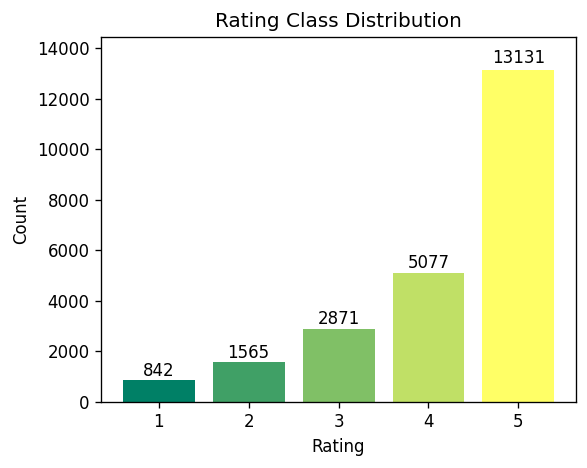

In [4]:
plt.figure(figsize=(5, 4), dpi=120)

rating_counts = df['Rating'].value_counts().sort_index()
cmap = plt.get_cmap('summer')
colors = [cmap(i / (len(rating_counts) - 1)) for i in range(len(rating_counts))]

bars = plt.bar(rating_counts.index, rating_counts.values, color=colors)

for bar, count in zip(bars, rating_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01, count,
             ha='center', va='bottom', fontsize=10)

plt.ylim(top=max(rating_counts.values) * 1.1)  # Optional for padding
plt.title('Rating Class Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [5]:
# Drop neutral rows
# Categorize 1 and 2 ratings as negative polarity while 4 and 5 as positive polarity.
df = df[df.Rating != 3].dropna(subset=['Review Text'])
df['Sentiment'] = (df.Rating >= 4).astype(int)

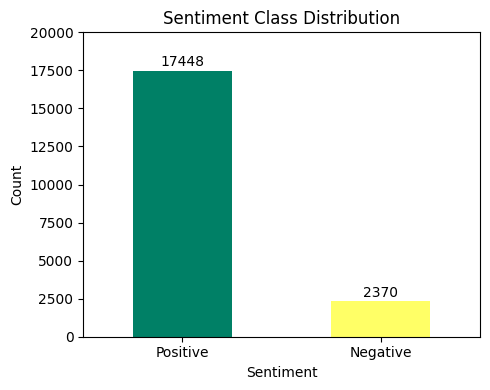

In [6]:
colors = [cmap(0.0), cmap(1.0)]  # Opposite ends for contrast

# Count sentiment classes
sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(5, 4))
ax = sentiment_counts.plot(kind='bar', color=colors)

# Add value labels on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height * 1.01, int(height),
            ha='center', va='bottom', fontsize=10)

plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Positive', 'Negative'], rotation=0)
plt.ylim(0, 20000)
plt.tight_layout()
plt.show()

In [7]:
# Split the data
train_df, test_df = train_test_split(df, train_size=0.8, random_state=0)
y_train, y_test = train_df.Sentiment.values, test_df.Sentiment.values
train_texts = train_df['Review Text'].astype(str).tolist()
test_texts  = test_df['Review Text'].astype(str).tolist()

In [8]:
# Initialize BERT encoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model     = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=False, return_dict=True)
model.to(device).eval()

# Helper to encode in batches
def encode(texts, batch_size=32):
    all_embeds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            out = model(**enc)
        cls_emb = out.last_hidden_state[:,0,:]
        all_embeds.append(cls_emb.cpu().numpy())
    return np.vstack(all_embeds)

# Create the embedding matrices
X_train = encode(train_texts, batch_size=16)
X_test  = encode(test_texts,  batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
# Fit your classifiers
lr  = LogisticRegression(max_iter=1000).fit(X_train, y_train)
nb  = GaussianNB().fit(X_train, y_train)
svm = SVC().fit(X_train, y_train)

# Evaluate
for name, clf in [('Logistic Regression', lr),
                  ('GaussianNB', nb),
                  ('SVM', svm)]:
    print(f"--- {name} ---")
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       494
           1       0.95      0.97      0.96      3470

    accuracy                           0.93      3964
   macro avg       0.86      0.81      0.83      3964
weighted avg       0.93      0.93      0.93      3964

--- GaussianNB ---
              precision    recall  f1-score   support

           0       0.40      0.83      0.54       494
           1       0.97      0.82      0.89      3470

    accuracy                           0.82      3964
   macro avg       0.68      0.82      0.71      3964
weighted avg       0.90      0.82      0.85      3964

--- SVM ---
              precision    recall  f1-score   support

           0       0.81      0.51      0.62       494
           1       0.93      0.98      0.96      3470

    accuracy                           0.92      3964
   macro avg       0.87      0.75      0.79      3964
weighted avg   

# Handling Imbalance Dataset - Undersampling

In [10]:
# Undersample the majority class
min_class_count = df['Sentiment'].value_counts().min()

# Sample the same number of instances from both classes and concatenate
df_balanced = pd.concat([
    df[df['Sentiment'] == 1].sample(min_class_count, random_state=42),
    df[df['Sentiment'] == 0].sample(min_class_count, random_state=42)
]).sample(frac=1, random_state=42)  # Shuffle the combined dataset

print(df_balanced['Sentiment'].value_counts())  # Check the new class distribution

Sentiment
1    2370
0    2370
Name: count, dtype: int64


In [11]:
train2_df, test2_df = train_test_split(df_balanced, train_size=0.8, random_state=0)
y2_train, y2_test = train2_df.Sentiment.values, test2_df.Sentiment.values
train2_texts = train2_df['Review Text'].astype(str).tolist()
test2_texts  = test2_df['Review Text'].astype(str).tolist()

X2_train = encode(train2_texts, batch_size=16)
X2_test  = encode(test2_texts,  batch_size=16)

In [12]:
lr2  = LogisticRegression(max_iter=1000).fit(X2_train, y2_train)
nb2  = GaussianNB().fit(X2_train, y2_train)
svm2 = SVC().fit(X2_train, y2_train)

# 6. Evaluate
for name, clf in [('Logistic Regression', lr2),
                  ('GaussianNB', nb2),
                  ('SVM', svm2)]:
    print(f"--- {name} ---")
    y2_pred = clf.predict(X2_test)
    print(classification_report(y2_test, y2_pred))

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       465
           1       0.89      0.87      0.88       483

    accuracy                           0.88       948
   macro avg       0.88      0.88      0.88       948
weighted avg       0.88      0.88      0.88       948

--- GaussianNB ---
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       465
           1       0.87      0.80      0.83       483

    accuracy                           0.83       948
   macro avg       0.84      0.84      0.83       948
weighted avg       0.84      0.83      0.83       948

--- SVM ---
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       465
           1       0.92      0.84      0.88       483

    accuracy                           0.88       948
   macro avg       0.88      0.88      0.88       948
weighted avg   

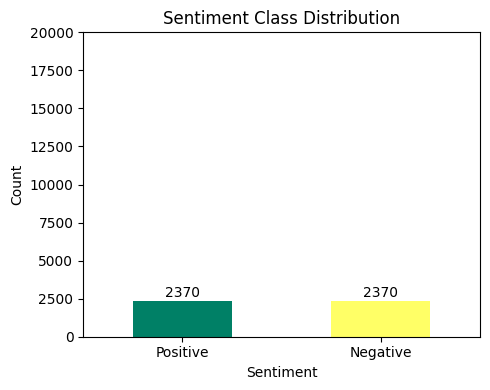

In [13]:
colors = [cmap(0.0), cmap(1.0)]  # Opposite ends for contrast

# Count sentiment classes
sentiment_counts = df_balanced['Sentiment'].value_counts()

plt.figure(figsize=(5, 4))
ax = sentiment_counts.plot(kind='bar', color=colors)

# Add value labels on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height * 1.01, int(height),
            ha='center', va='bottom', fontsize=10)

plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Positive', 'Negative'], rotation=0)
plt.ylim(0, 20000)
plt.tight_layout()
plt.show()

# Handling Imbalance Dataset - Use class_weight parameters

In [14]:
# Fit your classifiers
lr4  = LogisticRegression(class_weight='balanced', max_iter=1000).fit(X_train, y_train)
svm4 = SVC(class_weight='balanced').fit(X_train, y_train)

# Evaluate
for name, clf in [('Logistic Regression', lr4),
                  ('SVM', svm4)]:
    print(f"--- {name} ---")
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.57      0.84      0.68       494
           1       0.98      0.91      0.94      3470

    accuracy                           0.90      3964
   macro avg       0.77      0.88      0.81      3964
weighted avg       0.93      0.90      0.91      3964

--- SVM ---
              precision    recall  f1-score   support

           0       0.53      0.88      0.66       494
           1       0.98      0.89      0.93      3470

    accuracy                           0.89      3964
   macro avg       0.76      0.88      0.80      3964
weighted avg       0.92      0.89      0.90      3964

